In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm

In [ ]:
# Parameters of the Axelrod model
grid_size = 50
F = 3
q = 10

# Parameter for the noise
noise = 0.01

# Parameter for the mass media influence
media = 0.01

In [ ]:
def calculate_global_culture(cg):
    L, _, F = cg.shape
    culture_int = np.sum(cg * (q ** np.arange(F)), axis=2)
    unique_vals, counts = np.unique(culture_int, return_counts=True)
    most_common_culture_int = unique_vals[np.argmax(counts)]
    most_common_culture = np.zeros(F)
    for i in range(F-1, -1, -1):
        most_common_culture[i] = most_common_culture_int % q
        most_common_culture_int //= q
    return most_common_culture

def simulation_step(cg):
    x, y = np.random.randint(grid_size, size=2)
    dx, dy = np.random.choice([-1, 0, 1], size=2)
    nx, ny = (x + dx) % grid_size, (y + dy) % grid_size
    if any(cg[x, y, :] == cg[nx, ny, :]):
        differing_features = np.where(cg[x, y, :] != cg[nx, ny, :])[0]
        if len(differing_features) > 0:
            f = np.random.choice(differing_features)
            cg[x, y, f] = cg[nx, ny, f]
    return cg

def simulation_step_with_noise(cg):
    cg = simulation_step(cg)
    if np.random.rand() < noise:
        x, y = np.random.randint(grid_size, size=2)
        f = np.random.randint(F)
        cg[x, y, f] = np.random.randint(q)
    return cg

def simulation_step_with_media(cg, global_culture):
    cg = simulation_step(cg)
    if np.random.rand() < media:
        x, y = np.random.randint(grid_size, size=2)
        cg[x, y, :] = global_culture
    return cg

def simulation_step_with_noise_and_media(cg, global_culture):
    cg = simulation_step_with_noise(cg)
    if np.random.rand() < media:
        x, y = np.random.randint(grid_size, size=2)
        cg[x, y, :] = global_culture
    return cg

def calculate_Smax_norm(cg, q):
    L, _, F = cg.shape
    culture_int = np.sum(cg * (q ** np.arange(F)), axis=2)
    unique_vals, counts = np.unique(culture_int, return_counts=True)
    max_count = np.max(counts)
    Smax_norm = max_count / (L ** 2)
    return Smax_norm

def count_unique_cultures(cg, q):
    L, _, F = cg.shape
    culture_int = np.sum(cg * (q ** np.arange(F)), axis=2)
    unique_vals = np.unique(culture_int)
    return len(unique_vals)

def run_simulation(simulation_function, title_suffix):
    culture_grid = np.random.randint(q, size=(grid_size, grid_size, F))
    initial_culture_integers = np.sum(culture_grid * (q ** np.arange(F)), axis=2)
    smax_values = []
    unique_cultures_values = []

    global_culture = calculate_global_culture(culture_grid)

    previous_culture_grid = np.copy(culture_grid)
    consecutive_cycles = 0
    max_consecutive_cycles = 1000

    for step in tqdm(range(60000000), desc="Running simulation " + title_suffix):
        if simulation_function.__name__ in ["simulation_step_with_media", "simulation_step_with_noise_and_media"]:
            culture_grid = simulation_function(culture_grid, global_culture)
        else:
            culture_grid = simulation_function(culture_grid)

        smax = calculate_Smax_norm(culture_grid, q)
        smax_values.append(smax)
        unique_cultures_values.append(count_unique_cultures(culture_grid, q))

        # Check for consecutive cycles with no change in the culture grid
        if np.array_equal(culture_grid, previous_culture_grid):
            consecutive_cycles += 1
        else:
            consecutive_cycles = 0

        if consecutive_cycles >= max_consecutive_cycles:
            break

        previous_culture_grid = np.copy(culture_grid)

    final_culture_integers = np.sum(culture_grid * (q ** np.arange(F)), axis=2)
    cmap = colors.ListedColormap(np.random.rand(q**F, 3))

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(initial_culture_integers, cmap=cmap)
    axs[0].set_title('Initial ' + title_suffix)
    axs[1].imshow(final_culture_integers, cmap=cmap)
    axs[1].set_title('Final ' + title_suffix)
    plt.show()

    plt.figure(figsize=(10, 4.8))
    plt.plot(smax_values)
    mean_size = np.mean(smax_values)
    plt.axhline(y=mean_size, linestyle='dotted', color='r')
    plt.title('Smax Ratio ' + title_suffix)
    plt.show()

    plt.figure(figsize=(10, 4.8))
    plt.plot(unique_cultures_values)
    plt.title('Unique Cultures ' + title_suffix)
    plt.show()

Running simulation without variations:  51%|█████     | 30428529/60000000 [1:48:07<1:45:04, 4690.52it/s] 


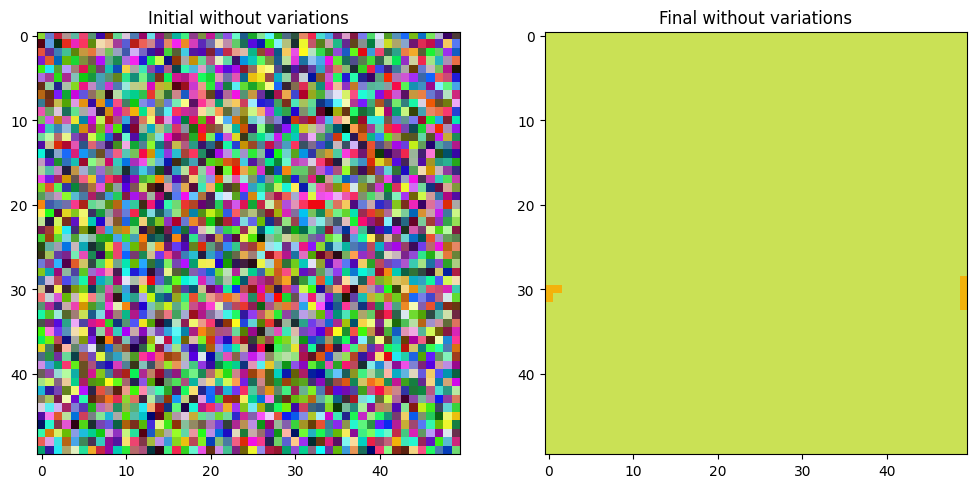

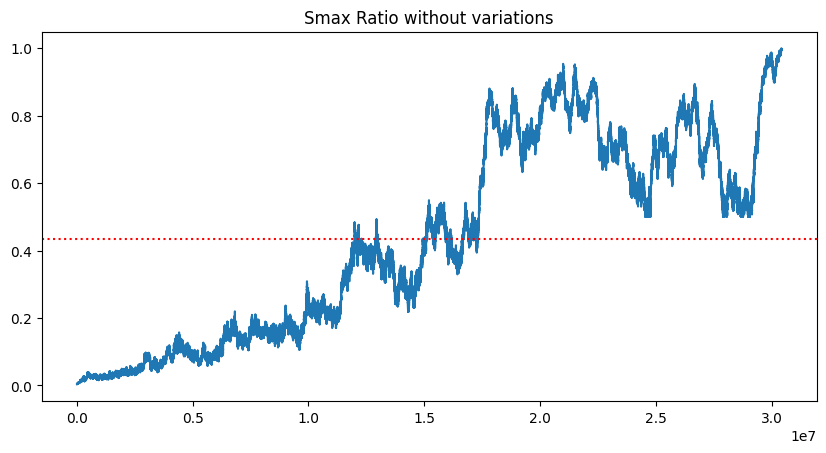

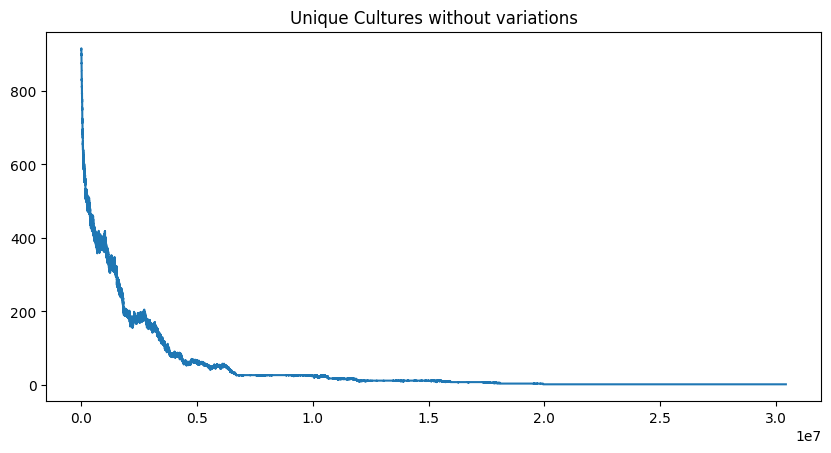

Running simulation with noise: 100%|██████████| 60000000/60000000 [4:44:49<00:00, 3510.93it/s]  


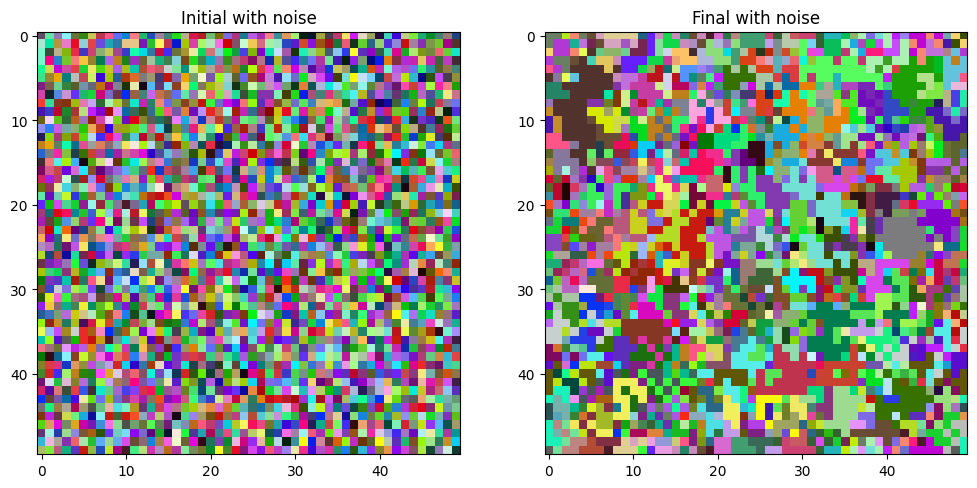

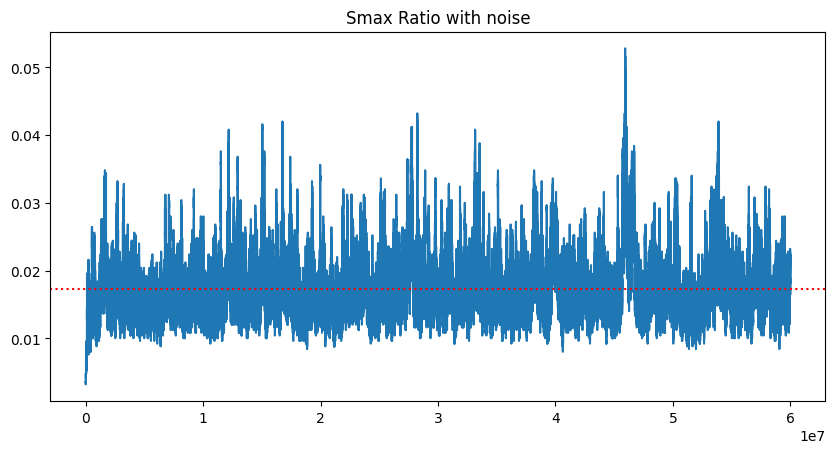

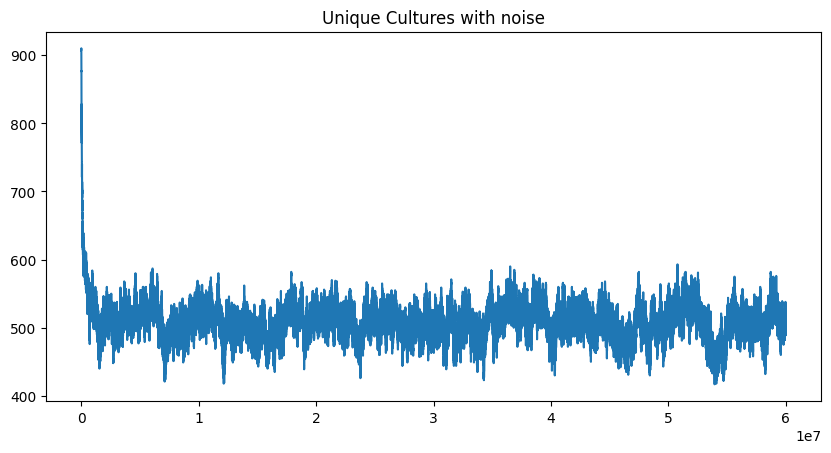

Running simulation with media:   2%|▏         | 1217001/60000000 [03:28<2:47:46, 5839.42it/s]


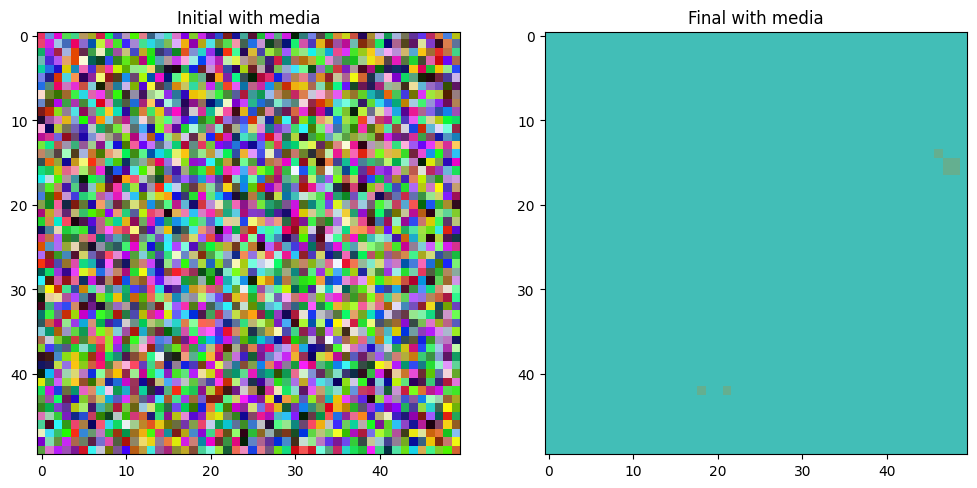

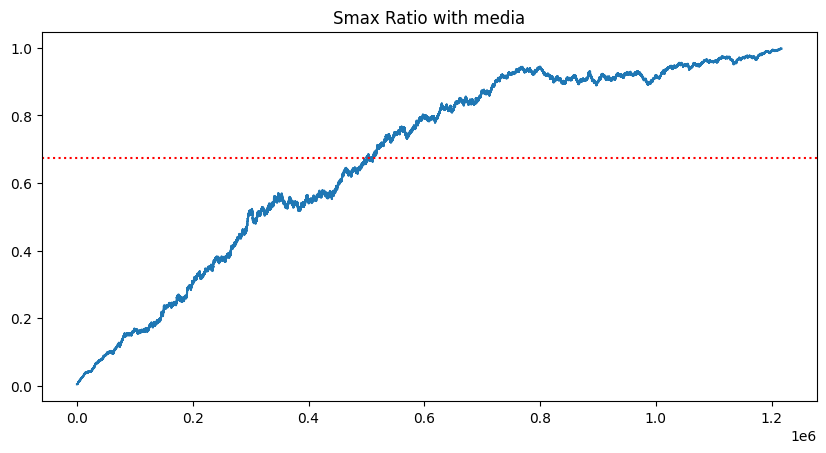

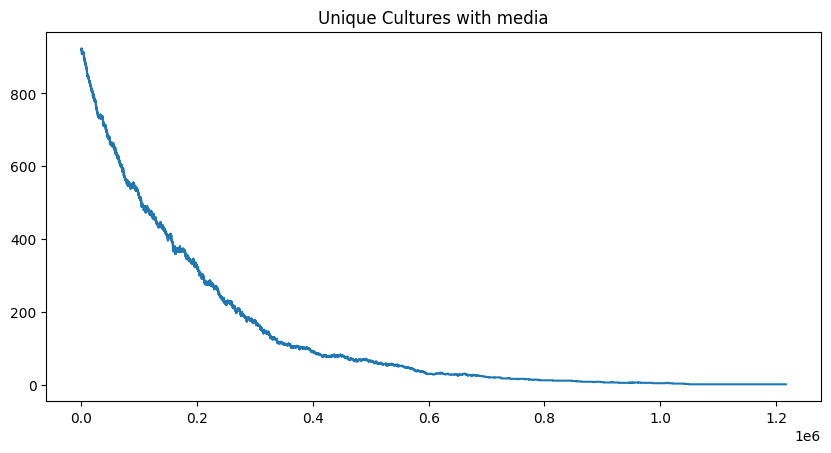

Running simulation with noise and media: 100%|██████████| 60000000/60000000 [3:06:07<00:00, 5372.89it/s]  


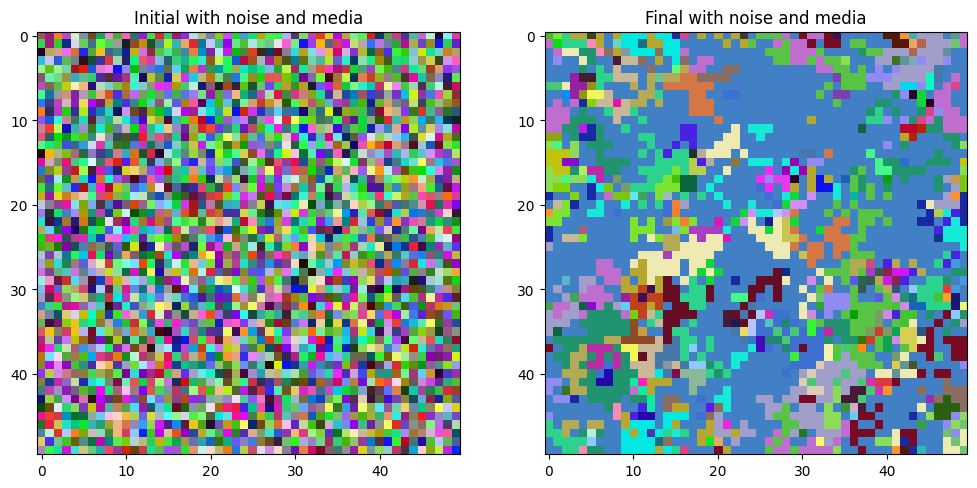

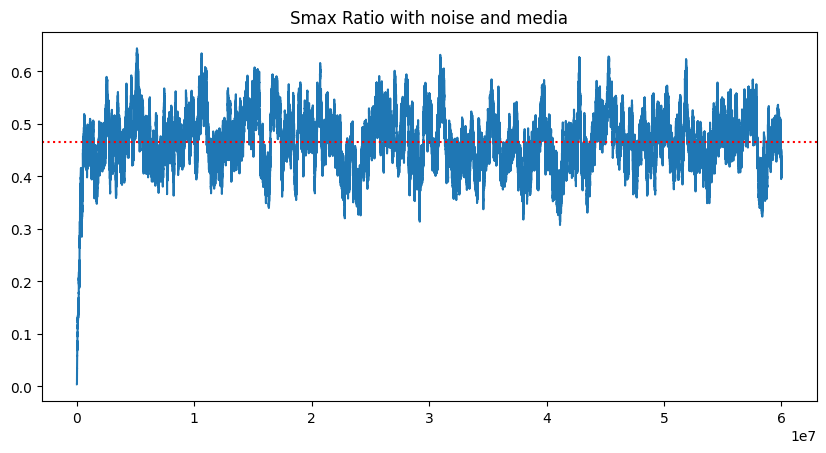

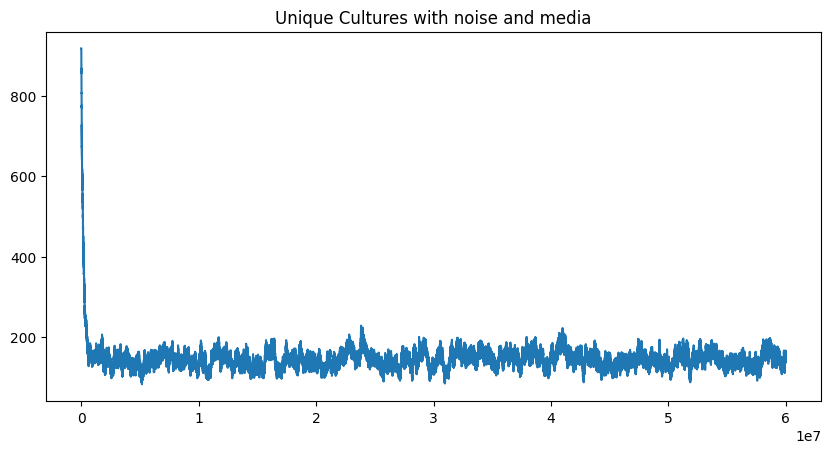

In [3]:
run_simulation(simulation_step, "without variations")
run_simulation(simulation_step_with_noise, "with noise")
run_simulation(simulation_step_with_media, "with media")
run_simulation(simulation_step_with_noise_and_media, "with noise and media")